In [1]:
import torch
torch.cuda.is_available()

True

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from tqdm.auto import tqdm

# Define the Residual Block
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.ca = ChannelAttention(out_channels)  # Add channel attention

        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out

# introduce attention mechanism
class ChannelAttention(nn.Module):
    def __init__(self, in_channels, reduction_ratio=16):
        super(ChannelAttention, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.max_pool = nn.AdaptiveMaxPool2d(1)
        self.fc = nn.Sequential(
            nn.Conv2d(in_channels, in_channels // reduction_ratio, 1, bias=False),
            nn.ReLU(),
            nn.Conv2d(in_channels // reduction_ratio, in_channels, 1, bias=False)
        )
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        avg_out = self.fc(self.avg_pool(x))
        max_out = self.fc(self.max_pool(x))
        out = avg_out + max_out
        return self.sigmoid(out)


# Define the ResNet Model
class ResNet(nn.Module):
    def __init__(self, num_classes=10):
        super(ResNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(16)
        self.layer1 = ResidualBlock(16, 32, stride=2)
        self.layer2 = ResidualBlock(32, 64, stride=2)
        self.fc = nn.Linear(64, num_classes)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = F.avg_pool2d(out, out.size()[3])
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        return out

# Hyperparameters
batch_size = 64
learning_rate = 0.01
num_epochs = 10

# Data transformations
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Load the dataset
train_dataset = datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)

train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

# Initialize the model, loss function, and optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ResNet(num_classes=10).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Training loop
for epoch in tqdm(range(num_epochs)):
    for i, (images, labels) in enumerate(train_loader):
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if (i+1) % 100 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{len(train_loader)}], Loss: {loss.item():.4f}')

# Test the model
model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    print(f'Accuracy of the model on the test images: {100 * correct / total}%')


100%|██████████| 26421880/26421880 [00:02<00:00, 10421046.24it/s]


Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 177076.24it/s]


Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:08<00:00, 536255.16it/s]


Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 8263404.90it/s]


Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



  0%|          | 0/10 [00:00<?, ?it/s]

Epoch [1/10], Step [100/938], Loss: 0.6267
Epoch [1/10], Step [200/938], Loss: 0.5904
Epoch [1/10], Step [300/938], Loss: 0.6815
Epoch [1/10], Step [400/938], Loss: 0.4585
Epoch [1/10], Step [500/938], Loss: 0.3254
Epoch [1/10], Step [600/938], Loss: 0.3709
Epoch [1/10], Step [700/938], Loss: 0.4203
Epoch [1/10], Step [800/938], Loss: 0.4400
Epoch [1/10], Step [900/938], Loss: 0.2814
Epoch [2/10], Step [100/938], Loss: 0.3768
Epoch [2/10], Step [200/938], Loss: 0.3699
Epoch [2/10], Step [300/938], Loss: 0.3449
Epoch [2/10], Step [400/938], Loss: 0.4335
Epoch [2/10], Step [500/938], Loss: 0.1254
Epoch [2/10], Step [600/938], Loss: 0.1571
Epoch [2/10], Step [700/938], Loss: 0.1620
Epoch [2/10], Step [800/938], Loss: 0.3080
Epoch [2/10], Step [900/938], Loss: 0.1819
Epoch [3/10], Step [100/938], Loss: 0.2937
Epoch [3/10], Step [200/938], Loss: 0.1890
Epoch [3/10], Step [300/938], Loss: 0.1753
Epoch [3/10], Step [400/938], Loss: 0.2703
Epoch [3/10], Step [500/938], Loss: 0.2005
Epoch [3/10

In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from tqdm import tqdm

# Define the Residual Block
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out

# Define the ResNet Model
class ResNet(nn.Module):
    def __init__(self, num_classes=10):
        super(ResNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(64, 64, stride=1, num_blocks=2)
        self.layer2 = self._make_layer(64, 128, stride=2, num_blocks=2)
        self.layer3 = self._make_layer(128, 256, stride=2, num_blocks=2)
        self.layer4 = self._make_layer(256, 512, stride=2, num_blocks=2)
        self.fc = nn.Linear(512, num_classes)

    def _make_layer(self, in_channels, out_channels, stride, num_blocks):
        layers = [ResidualBlock(in_channels, out_channels, stride=stride)]
        for _ in range(1, num_blocks):
            layers.append(ResidualBlock(out_channels, out_channels))
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, out.size()[3])
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        return out

# Hyperparameters
batch_size = 256
learning_rate = 0.01
num_epochs = 50

# Data transformations and augmentation
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Load the dataset
train_dataset = datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)

train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

# Initialize the model, loss function, and optimizer
model = ResNet(num_classes=10).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Training loop
for epoch in tqdm(range(num_epochs)):
    model.train()
    for i, (images, labels) in enumerate(train_loader):
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # Validation
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    accuracy = 100 * correct / total
    print(f'Epoch [{epoch+1}/{num_epochs}], Accuracy: {accuracy:.2f}%')

# Final test accuracy
print(f'Final Test Accuracy: {accuracy:.2f}%')


  2%|▏         | 1/50 [00:25<21:12, 25.97s/it]

Epoch [1/50], Accuracy: 68.38%


  4%|▍         | 2/50 [00:51<20:46, 25.97s/it]

Epoch [2/50], Accuracy: 85.69%


  6%|▌         | 3/50 [01:17<20:19, 25.94s/it]

Epoch [3/50], Accuracy: 86.28%


  8%|▊         | 4/50 [01:43<19:53, 25.95s/it]

Epoch [4/50], Accuracy: 77.82%


 10%|█         | 5/50 [02:09<19:29, 25.99s/it]

Epoch [5/50], Accuracy: 88.34%


 12%|█▏        | 6/50 [02:35<19:02, 25.97s/it]

Epoch [6/50], Accuracy: 90.58%


 14%|█▍        | 7/50 [03:01<18:37, 25.98s/it]

Epoch [7/50], Accuracy: 90.16%


 16%|█▌        | 8/50 [03:27<18:10, 25.97s/it]

Epoch [8/50], Accuracy: 91.08%


 18%|█▊        | 9/50 [03:53<17:45, 25.98s/it]

Epoch [9/50], Accuracy: 88.55%


 20%|██        | 10/50 [04:19<17:20, 26.02s/it]

Epoch [10/50], Accuracy: 91.47%


 22%|██▏       | 11/50 [04:45<16:52, 25.97s/it]

Epoch [11/50], Accuracy: 89.97%


 24%|██▍       | 12/50 [05:11<16:26, 25.96s/it]

Epoch [12/50], Accuracy: 90.84%


 26%|██▌       | 13/50 [05:37<16:00, 25.96s/it]

Epoch [13/50], Accuracy: 90.97%


 28%|██▊       | 14/50 [06:03<15:34, 25.97s/it]

Epoch [14/50], Accuracy: 89.45%


 30%|███       | 15/50 [06:29<15:10, 26.03s/it]

Epoch [15/50], Accuracy: 88.97%


 32%|███▏      | 16/50 [06:55<14:44, 26.02s/it]

Epoch [16/50], Accuracy: 90.63%


 34%|███▍      | 17/50 [07:21<14:18, 26.01s/it]

Epoch [17/50], Accuracy: 91.40%


 36%|███▌      | 18/50 [07:47<13:51, 25.98s/it]

Epoch [18/50], Accuracy: 93.17%


 38%|███▊      | 19/50 [08:13<13:25, 25.99s/it]

Epoch [19/50], Accuracy: 92.33%


 40%|████      | 20/50 [08:39<12:59, 25.98s/it]

Epoch [20/50], Accuracy: 91.28%


 42%|████▏     | 21/50 [09:05<12:33, 25.98s/it]

Epoch [21/50], Accuracy: 92.16%


 44%|████▍     | 22/50 [09:31<12:07, 25.97s/it]

Epoch [22/50], Accuracy: 91.36%


 46%|████▌     | 23/50 [09:57<11:40, 25.95s/it]

Epoch [23/50], Accuracy: 92.97%


 48%|████▊     | 24/50 [10:23<11:15, 25.97s/it]

Epoch [24/50], Accuracy: 92.89%


 50%|█████     | 25/50 [10:49<10:49, 25.98s/it]

Epoch [25/50], Accuracy: 92.44%


 52%|█████▏    | 26/50 [11:15<10:23, 25.97s/it]

Epoch [26/50], Accuracy: 92.76%


 54%|█████▍    | 27/50 [11:41<09:57, 25.96s/it]

Epoch [27/50], Accuracy: 92.88%


 56%|█████▌    | 28/50 [12:07<09:31, 25.98s/it]

Epoch [28/50], Accuracy: 92.78%


 58%|█████▊    | 29/50 [12:33<09:05, 25.96s/it]

Epoch [29/50], Accuracy: 92.99%


 60%|██████    | 30/50 [12:59<08:39, 25.95s/it]

Epoch [30/50], Accuracy: 93.03%


 62%|██████▏   | 31/50 [13:25<08:13, 25.97s/it]

Epoch [31/50], Accuracy: 91.02%


 64%|██████▍   | 32/50 [13:51<07:47, 25.98s/it]

Epoch [32/50], Accuracy: 93.24%


 66%|██████▌   | 33/50 [14:17<07:22, 26.01s/it]

Epoch [33/50], Accuracy: 92.95%


 68%|██████▊   | 34/50 [14:43<06:56, 26.02s/it]

Epoch [34/50], Accuracy: 93.46%


 70%|███████   | 35/50 [15:09<06:30, 26.04s/it]

Epoch [35/50], Accuracy: 92.45%


 72%|███████▏  | 36/50 [15:35<06:04, 26.03s/it]

Epoch [36/50], Accuracy: 92.71%


 74%|███████▍  | 37/50 [16:01<05:38, 26.03s/it]

Epoch [37/50], Accuracy: 93.21%


 76%|███████▌  | 38/50 [16:27<05:12, 26.02s/it]

Epoch [38/50], Accuracy: 93.38%


 78%|███████▊  | 39/50 [16:53<04:46, 26.03s/it]

Epoch [39/50], Accuracy: 93.60%


 80%|████████  | 40/50 [17:19<04:20, 26.03s/it]

Epoch [40/50], Accuracy: 92.50%


 82%|████████▏ | 41/50 [17:45<03:54, 26.03s/it]

Epoch [41/50], Accuracy: 92.85%


 84%|████████▍ | 42/50 [18:11<03:28, 26.04s/it]

Epoch [42/50], Accuracy: 92.99%


 86%|████████▌ | 43/50 [18:37<03:02, 26.04s/it]

Epoch [43/50], Accuracy: 93.08%


 88%|████████▊ | 44/50 [19:03<02:36, 26.01s/it]

Epoch [44/50], Accuracy: 93.52%


 90%|█████████ | 45/50 [19:29<02:09, 25.99s/it]

Epoch [45/50], Accuracy: 93.52%


 92%|█████████▏| 46/50 [19:55<01:44, 26.04s/it]

Epoch [46/50], Accuracy: 92.96%


 94%|█████████▍| 47/50 [20:21<01:18, 26.03s/it]

Epoch [47/50], Accuracy: 93.09%


 96%|█████████▌| 48/50 [20:47<00:52, 26.06s/it]

Epoch [48/50], Accuracy: 93.12%


 98%|█████████▊| 49/50 [21:13<00:26, 26.06s/it]

Epoch [49/50], Accuracy: 92.40%


100%|██████████| 50/50 [21:40<00:00, 26.00s/it]

Epoch [50/50], Accuracy: 93.38%
Final Test Accuracy: 93.38%


In [8]:
# Training loop
for epoch in tqdm(range(num_epochs)):
    model.train()
    for i, (images, labels) in enumerate(train_loader):
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # Validation
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    accuracy = 100 * correct / total
    print(f'Epoch [{epoch+1}/{num_epochs}], Accuracy: {accuracy:.2f}%')

# Final test accuracy
print(f'Final Test Accuracy: {accuracy:.2f}%')

  2%|▏         | 1/50 [00:26<21:37, 26.48s/it]

Epoch [1/50], Accuracy: 93.55%


  4%|▍         | 2/50 [00:53<21:12, 26.52s/it]

Epoch [2/50], Accuracy: 93.91%


  6%|▌         | 3/50 [01:19<20:41, 26.42s/it]

Epoch [3/50], Accuracy: 93.59%


  8%|▊         | 4/50 [01:45<20:15, 26.42s/it]

Epoch [4/50], Accuracy: 93.47%


 10%|█         | 5/50 [02:12<19:47, 26.39s/it]

Epoch [5/50], Accuracy: 93.70%


 12%|█▏        | 6/50 [02:38<19:21, 26.39s/it]

Epoch [6/50], Accuracy: 93.79%


 14%|█▍        | 7/50 [03:04<18:51, 26.32s/it]

Epoch [7/50], Accuracy: 93.27%


 16%|█▌        | 8/50 [03:30<18:21, 26.22s/it]

Epoch [8/50], Accuracy: 93.58%


 18%|█▊        | 9/50 [03:56<17:52, 26.15s/it]

Epoch [9/50], Accuracy: 93.73%


 20%|██        | 10/50 [04:22<17:24, 26.12s/it]

Epoch [10/50], Accuracy: 93.79%


 22%|██▏       | 11/50 [04:48<16:58, 26.11s/it]

Epoch [11/50], Accuracy: 93.68%


 24%|██▍       | 12/50 [05:14<16:31, 26.09s/it]

Epoch [12/50], Accuracy: 93.81%


 26%|██▌       | 13/50 [05:40<16:04, 26.06s/it]

Epoch [13/50], Accuracy: 93.37%


 28%|██▊       | 14/50 [06:06<15:38, 26.06s/it]

Epoch [14/50], Accuracy: 93.50%


 30%|███       | 15/50 [06:32<15:11, 26.04s/it]

Epoch [15/50], Accuracy: 93.62%


 32%|███▏      | 16/50 [06:58<14:45, 26.05s/it]

Epoch [16/50], Accuracy: 93.63%


 34%|███▍      | 17/50 [07:25<14:19, 26.05s/it]

Epoch [17/50], Accuracy: 93.61%


 36%|███▌      | 18/50 [07:51<13:53, 26.05s/it]

Epoch [18/50], Accuracy: 93.32%


 38%|███▊      | 19/50 [08:17<13:26, 26.03s/it]

Epoch [19/50], Accuracy: 93.87%


 40%|████      | 20/50 [08:43<13:00, 26.02s/it]

Epoch [20/50], Accuracy: 93.42%


 42%|████▏     | 21/50 [09:09<12:35, 26.05s/it]

Epoch [21/50], Accuracy: 93.57%


 44%|████▍     | 22/50 [09:35<12:09, 26.05s/it]

Epoch [22/50], Accuracy: 93.78%


 46%|████▌     | 23/50 [10:01<11:43, 26.07s/it]

Epoch [23/50], Accuracy: 93.40%


 48%|████▊     | 24/50 [10:27<11:18, 26.09s/it]

Epoch [24/50], Accuracy: 93.67%


 50%|█████     | 25/50 [10:53<10:51, 26.05s/it]

Epoch [25/50], Accuracy: 93.80%


 52%|█████▏    | 26/50 [11:19<10:25, 26.05s/it]

Epoch [26/50], Accuracy: 93.48%


 54%|█████▍    | 27/50 [11:45<09:59, 26.06s/it]

Epoch [27/50], Accuracy: 93.48%


 56%|█████▌    | 28/50 [12:11<09:32, 26.04s/it]

Epoch [28/50], Accuracy: 93.63%


 58%|█████▊    | 29/50 [12:37<09:06, 26.02s/it]

Epoch [29/50], Accuracy: 93.82%


 60%|██████    | 30/50 [13:03<08:41, 26.06s/it]

Epoch [30/50], Accuracy: 93.80%


 62%|██████▏   | 31/50 [13:29<08:14, 26.03s/it]

Epoch [31/50], Accuracy: 93.60%


 64%|██████▍   | 32/50 [13:55<07:49, 26.06s/it]

Epoch [32/50], Accuracy: 93.86%


 66%|██████▌   | 33/50 [14:21<07:23, 26.07s/it]

Epoch [33/50], Accuracy: 93.68%


 68%|██████▊   | 34/50 [14:47<06:56, 26.06s/it]

Epoch [34/50], Accuracy: 93.47%


 70%|███████   | 35/50 [15:13<06:30, 26.06s/it]

Epoch [35/50], Accuracy: 93.62%


 72%|███████▏  | 36/50 [15:40<06:05, 26.08s/it]

Epoch [36/50], Accuracy: 93.63%


 74%|███████▍  | 37/50 [16:06<05:38, 26.07s/it]

Epoch [37/50], Accuracy: 93.66%


 76%|███████▌  | 38/50 [16:31<05:12, 26.00s/it]

Epoch [38/50], Accuracy: 93.25%


 78%|███████▊  | 39/50 [16:58<04:46, 26.05s/it]

Epoch [39/50], Accuracy: 93.76%


 80%|████████  | 40/50 [17:24<04:20, 26.00s/it]

Epoch [40/50], Accuracy: 93.80%


 82%|████████▏ | 41/50 [17:50<03:54, 26.02s/it]

Epoch [41/50], Accuracy: 93.76%


 84%|████████▍ | 42/50 [18:15<03:27, 25.95s/it]

Epoch [42/50], Accuracy: 93.68%


 86%|████████▌ | 43/50 [18:41<03:01, 25.89s/it]

Epoch [43/50], Accuracy: 93.79%


 88%|████████▊ | 44/50 [19:07<02:35, 25.86s/it]

Epoch [44/50], Accuracy: 93.63%


 90%|█████████ | 45/50 [19:33<02:09, 25.86s/it]

Epoch [45/50], Accuracy: 93.54%


 92%|█████████▏| 46/50 [19:59<01:43, 25.86s/it]

Epoch [46/50], Accuracy: 93.57%


 94%|█████████▍| 47/50 [20:25<01:17, 25.95s/it]

Epoch [47/50], Accuracy: 93.53%


 96%|█████████▌| 48/50 [20:51<00:51, 25.98s/it]

Epoch [48/50], Accuracy: 93.68%


 98%|█████████▊| 49/50 [21:17<00:26, 26.04s/it]

Epoch [49/50], Accuracy: 93.49%


100%|██████████| 50/50 [21:43<00:00, 26.07s/it]

Epoch [50/50], Accuracy: 93.58%
Final Test Accuracy: 93.58%


In [9]:
!pip install torchmetrics mlxtend

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 840.4/840.4 kB 15.7 MB/s eta 0:00:00


In [22]:
device='cuda'

In [23]:
images = images.to(device)
model = model.to(device)

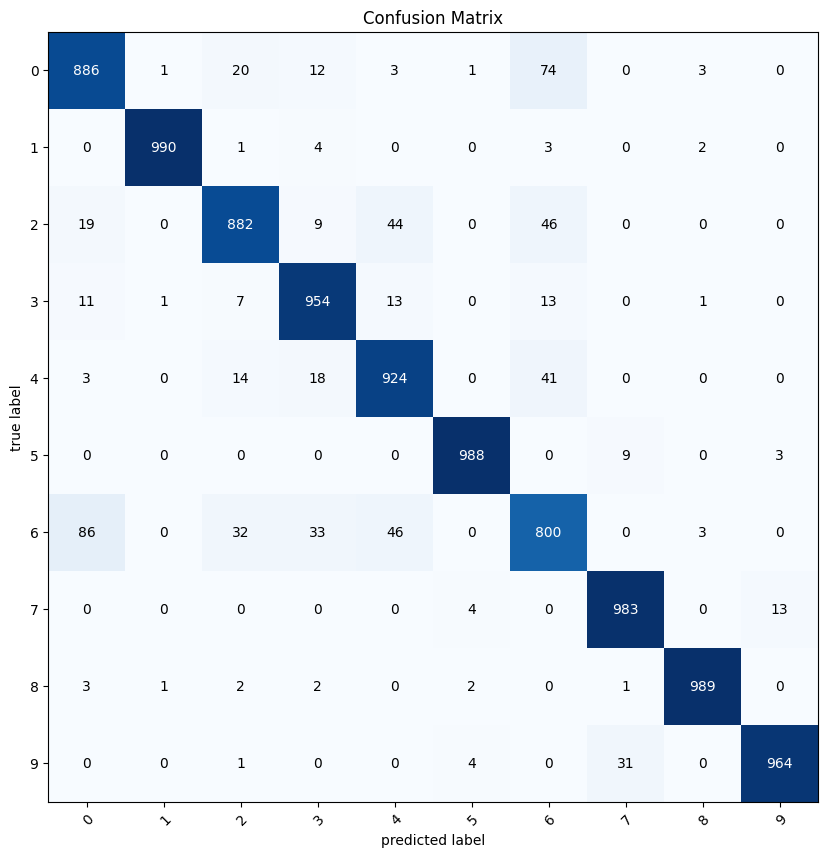

In [27]:
from torchmetrics import ConfusionMatrix
from mlxtend.plotting import plot_confusion_matrix
import matplotlib.pyplot as plt

# Initialize the confusion matrix metric
confmat = ConfusionMatrix(num_classes=10, task="multiclass").to(device)

# Compute the confusion matrix
model.eval()
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        preds = torch.argmax(outputs, dim=1)
        confmat.update(preds, labels)

# Get the confusion matrix
cm = confmat.compute().cpu().numpy()

# Plot the confusion matrix
fig, ax = plot_confusion_matrix(conf_mat=cm, figsize=(10, 10), class_names=[str(i) for i in range(10)])
plt.title('Confusion Matrix')
plt.show()

